In [854]:
using GaussianProcesses
using Random
using LinearAlgebra
using Distributions
using Plots
using Optim

# 1D Gaussian Process

http://krasserm.github.io/2018/03/19/gaussian-processes/?fbclid=IwAR30yTwSAVnt0F0ep91iTGupCRg5D-YjO4dQWBg89R-cTqerrDeL5JUMtfE

## Data generation

In [918]:
function kernel_1D(X1, X2, l = 1.0, sigma_f = 1.0)
    sq_dist = sum(X1.^2, dims = 2) .+ sum(X2.^2, dims = 2)'.- 2 * X1 * X2'
    δ = - 0.5/l
    d = -sq_dist/(2*l^2)
    cov = sigma_f * exp.(d)
    σ = cov + 0.000001*I # It gives Cholesky factorization error without this trick**
    return(σ)
end

kernel_1D (generic function with 3 methods)

In [925]:
X = LinRange(-5, 5, 50)
X = round.(X, digits = 1);

In [926]:
μ = zeros(size(X)[1]);

In [927]:
cov = kernel_1D(X,X);

In [928]:
mv_norm = MvNormal(μ, cov)

FullNormal(
dim: 50
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.000001 0.9801986733067557 … 1.396943943147109e-21 1.9287498479639178e-22; 0.9801986733067557 1.000001 … 9.72098502030078e-21 1.396943943147109e-21; … ; 1.396943943147109e-21 9.72098502030078e-21 … 1.000001 0.9801986733067557; 1.9287498479639178e-22 1.396943943147109e-21 … 0.9801986733067557 1.000001]
)


In [963]:
samples = rand(mv_norm, 3);

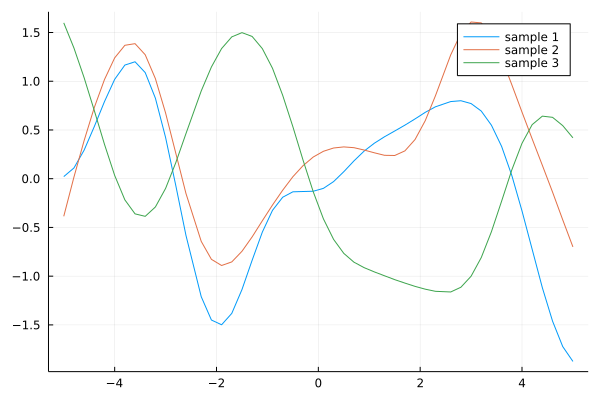

In [964]:
p = plot(X, samples[:,1], label = "sample 1")
plot!(p, X, samples[:,2], label = "sample 2")
plot!(p, X, samples[:,3], label = "sample 3")

In [1057]:
function posterior_0_noise(X, X_train, Y_train, l=1.0, sigma_f = 1.0)
    
    K = kernel_1D(X_train, X_train)
    K_ss = kernel_1D(X,X)
    K_inv = inv(K);
    
    sq_dist = sum(X_train.^2, dims = 2) .+ sum(X.^2, dims = 2)' .- 2 * X_train * X'
    δ = - 0.5/l
    d = -sq_dist/(2*l^2)
    K_s = sigma_f * exp.(d)
    
    mus = K_s' * K_inv * Y_train;
    
    cov_s = K_ss - (K_s' * K_inv * K_s)
    
    return(mus,cov_s)
end

posterior_0_noise (generic function with 3 methods)

In [965]:
function posterior(X, X_train, Y_train, l=1.0, sigma_f = 1.0, sigma_y = 1e-8)
    
    K = kernel_1D(X_train, X_train) + sigma_y^2 * I(size(X_train)[1])
    K_ss = kernel_1D(X,X) + sigma_y^2 * I(size(X)[1])
    K_inv = inv(K);
    
    sq_dist = sum(X_train.^2, dims = 2) .+ sum(X.^2, dims = 2)' .- 2 * X_train * X'
    δ = - 0.5/l
    d = -sq_dist/(2*l^2)
    K_s = sigma_f * exp.(d)
    
    mus = K_s' * K_inv * Y_train;
    
    cov_s = K_ss - (K_s' * K_inv * K_s)
    
    return(mus,cov_s)
end

posterior (generic function with 4 methods)

In [966]:
X_train = [-4, -3, -2, -1, 1]
Y_train = sin.(X_train)

5-element Vector{Float64}:
  0.7568024953079282
 -0.1411200080598672
 -0.9092974268256817
 -0.8414709848078965
  0.8414709848078965

In [967]:
μ_post, Σ_post = posterior(X, X_train, Y_train);

In [968]:
mv_norm_posterior = MvNormal(μ_post, Matrix(Hermitian(Σ_post)));

In [969]:
post_samples = rand(mv_norm_posterior, 3);

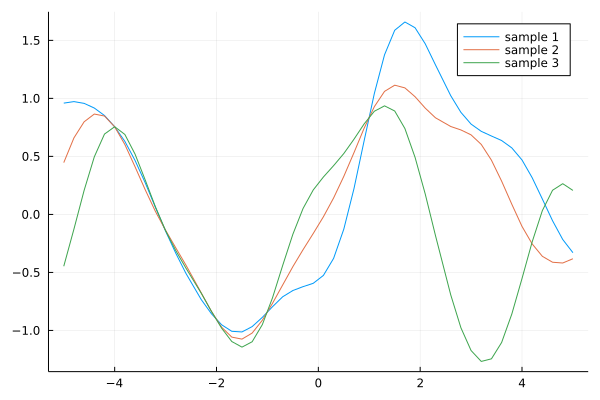

In [970]:
p = plot(X, post_samples[:,1], label = "sample 1")
plot!(p, X, post_samples[:,2], label = "sample 2")
plot!(p, X, post_samples[:,3], label = "sample 3")

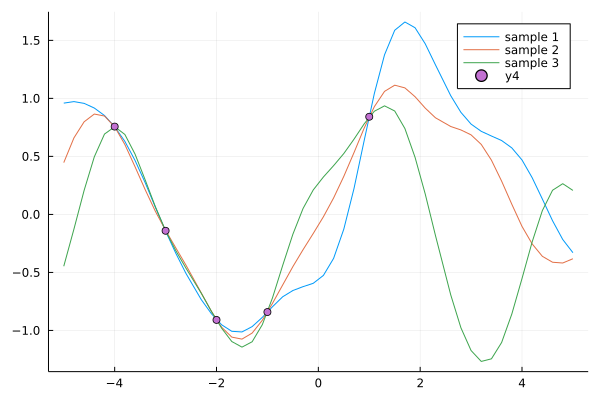

In [971]:
scatter!(p, X_train, Y_train)

In [1016]:
noise = 0.8

# Noisy training data

X_train = range(-3, 4, step = 1)
Y_train = sin.(X_train) + noise * rand(size(X_train)[1]);

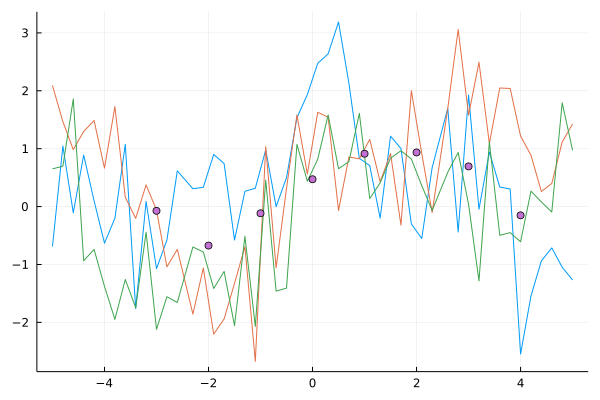

In [1017]:
mu_s, cov_s = posterior(X, X_train, Y_train, 1.0, 1.0, noise)
mv_norm_posterior = MvNormal(mu_s, Matrix(Hermitian(cov_s)))

post_samples = rand(mv_norm_posterior, 3)


p = plot(X, post_samples[:,1], label =false) 
plot!(p, X, post_samples[:,2], label =false)
plot!(p, X, post_samples[:,3], label =false)

scatter!(p, X_train, Y_train, label =false)

## Negative log-likelihood

In [1039]:
noise = 0.4
X_train = range(-3, 4, step = 1)

Y_train = sin.(X_train) + noise * rand(size(X_train)[1])

8-element Vector{Float64}:
 -0.011612477574164781
 -0.6201334136719558
 -0.6810291819092177
  0.18904982442704965
  0.9966998607174371
  0.9859469546923033
  0.39148874365898856
 -0.6967086893558486

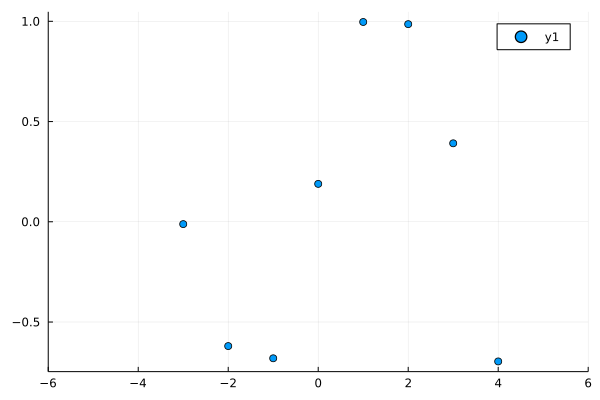

In [1042]:
scatter(X_train, Y_train, xlim = (-6,6))

In [1054]:
function neg_loglik_0_noise(X_train, Y_train, theta_1, theta_2)
    K = kernel_1D(X_train, X_train, theta_1, theta_2)
    comp1 = -0.5 * Y_train' * inv(K) * Y_train
    comp2 = -0.5*det(K)
    comp3 = -0.5*(size(Y_train)[1]) * log(2pi)
    
    return(comp1 + comp2 + comp3)
end

begin
    theta = [1.0, 1.0]
    neg_loglik_0_noise(X_train, Y_train, theta[1], theta[2])
end

-8.875155586314026

In [1044]:
function neg_loglik(X_train, Y_train, noise, theta_1, theta_2)
    K = kernel_1D(X_train, X_train, theta_1, theta_2) + noise^2 * I(size(X_train)[1])
    comp1 = -0.5 * Y_train' * inv(K) * Y_train
    comp2 = -0.5*det(K)
    comp3 = -0.5*(size(Y_train)[1]) * log(2pi)
    
    return(comp1 + comp2 + comp3)
end

begin
    theta = [1.0, 1.0]
    neg_loglik(X_train, Y_train, noise, theta[1], theta[2])
end

-8.723720266270814

In [1075]:
# theta 1 = l
# theta 2 = sigma_f
f = ((x, y),) -> neg_loglik_0_noise(X_train, Y_train, x, y)

initial_x = [2.0, 1.0]
lower = [1, 0.1]
upper = [3,4.0]

2-element Vector{Float64}:
 3.0
 4.0

In [1076]:
inner_optimizer = LBFGS()
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))
l_optim, sigma_f_optim = Optim.minimizer(results)

2-element Vector{Float64}:
 2.9999999983129655
 0.1000000006558773

In [1077]:
mu_s, cov_s = posterior_0_noise(X, X_train, Y_train, l_optim, sigma_f_optim)

([-0.009076597981089632, -0.009872957801604569, -0.010601457837509133, -0.011235982351142315, -0.011749299125849128, -0.012113695571471406, -0.012301704709879908, -0.012286905469562903, -0.012044777211844007, -0.011553584296007058  …  0.018064402863627316, 0.01425749572907184, 0.010315657403175665, 0.006303983285965931, 0.002287092715622885, -0.0016723537727821314, -0.005515031367469447, -0.009186184517342794, -0.012636685881706855, -0.015823896730752657], [0.9925220286563798 0.9723325356712675 … -0.0012432413716809768 -0.00110647414737909; 0.9723325356712675 0.991722297321961 … -0.0013978664915708628 -0.0012468651417505017; … ; -0.001243241371680979 -0.0013978664915708654 … 0.9875072895859157 0.9681405075674675; -0.001106474147379091 -0.0012468651417505033 … 0.9681405075674675 0.9883528580185512])

In [1072]:
Hermitian(cov_s)

50×50 Hermitian{Float64, Matrix{Float64}}:
  0.281721     0.224735    0.131735   …  -0.13377   -0.119401  -0.106266
  0.224735     0.204914    0.146754      -0.150079  -0.134251  -0.119749
  0.131735     0.146754    0.125744      -0.167906  -0.150527  -0.134565
  0.00957649   0.0529352   0.066756      -0.187331  -0.168307  -0.150791
 -0.131918    -0.0696729  -0.0275155     -0.208426  -0.187666  -0.168505
 -0.28165     -0.211242   -0.150196   …  -0.23126   -0.208676  -0.187777
 -0.428979    -0.360672   -0.291455      -0.255893  -0.231399  -0.208676
 -0.56513     -0.507327   -0.440197      -0.282375  -0.255893  -0.23126
 -0.684019    -0.64244    -0.585795      -0.310747  -0.282203  -0.255582
 -0.782461    -0.759943   -0.719497      -0.341038  -0.310365  -0.281683
 -0.859833    -0.856668   -0.835254   …  -0.37326   -0.340402  -0.309593
 -0.917417    -0.932017   -0.929923      -0.407412  -0.372321  -0.339327
 -0.957635    -0.987298   -1.00293       -0.443472  -0.406113  -0.370886
  ⋮      

In [1078]:
mv_norm_posterior = MvNormal(mu_s, Matrix(Hermitian(cov_s)));

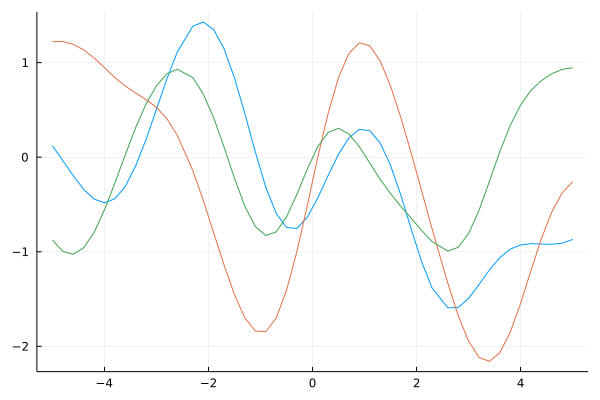

In [1081]:
post_samples = rand(mv_norm_posterior, 10)


p = plot(X, post_samples[:,1], label =false) 
plot!(p, X, post_samples[:,2], label =false)
plot!(p, X, post_samples[:,3], label =false)

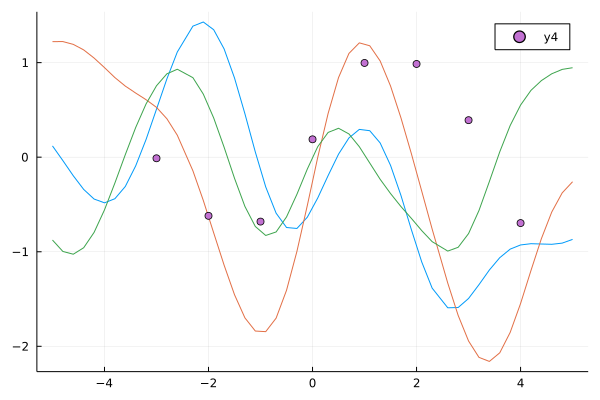

In [1082]:
scatter!(p, X_train, Y_train)

# The optimizer doesn't work properly

## 2D

In [1121]:
X_2D_1 = range(-5, 5, step = 0.1)
X_2D_2 = range(-5, 5, step = 0.1)

X_2D = hcat(X_2D_1, X_2D_2);

In [1122]:
size(X_2D)

(101, 2)

In [1123]:
X_2D_train = rand(Uniform(-4, 4), (100,2));

In [1124]:
Y_2D_train = sin.(0.5 * [LinearAlgebra.norm(X_2D_train[i, :]) for i in 1:size(X_2D_train)[1]]) + rand(size(X_2D_train)[1]);

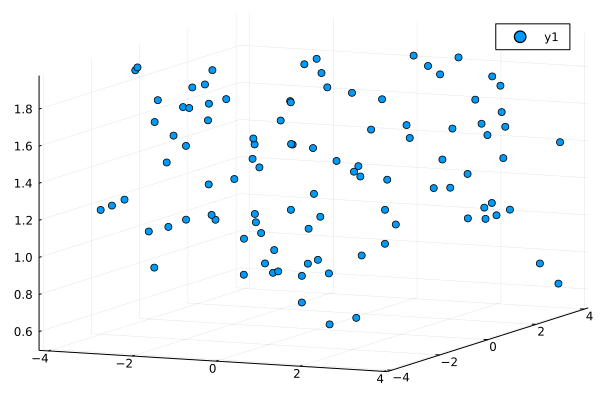

In [1125]:
scatter3d(X_2D_train[:, 1], X_2D_train[:, 2], Y_2D_train)

In [1126]:
f = ((x, y),) -> neg_loglik_0_noise(X_2D_train, Y_2D_train, x, y)

initial_x = [2.0, 1.0]
lower = [1, 0.1]
upper = [3,4.0]

2-element Vector{Float64}:
 3.0
 4.0

In [1127]:
inner_optimizer = LBFGS()
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))
l_optim, sigma_f_optim = Optim.minimizer(results)

2-element Vector{Float64}:
 2.9999999989410733
 0.1000000004121704

In [1248]:
mu_s, cov_s = posterior_0_noise(X_2D, X_2D_train, Y_2D_train)

([-4.794529639709708, 0.27983007413592986, 1.512742324555802, 1.4850411577126579, 2.821305825940726, 0.23734244091497203, 3.7332926388819487, 2.4074670972122476, -2.4177700362909036, 0.5506999400329846  …  -1.1958670172272425, -0.2922098366639716, -0.47821068125127575, 1.3555057600963383, -14.188086715774716, -0.2608365536681606, 2.3257520125608835, 0.684587570700387, 1.7182785291075504, -5.487355268680403], [0.010765985337337969 -7.570618459045228e-5 … 5.497189044481658e-5 4.1108089722308596e-5; -7.570618455187653e-5 0.02628528614436665 … -7.918218508612232e-5 -0.026079201998041715; … ; 5.497189037282816e-5 -7.91821851080102e-5 … 0.0004955882731465522 -0.00034791253614568256; 4.1108089761327535e-5 -0.026079201998127396 … -0.00034791253613181204 0.5771632483118934])

In [1249]:
mv_norm_posterior_2D = MvNormal(mu_s, Matrix(Hermitian(cov_s)));

In [1250]:
sample2D = rand(mv_norm_posterior_2D);

In [1251]:
X_2D;

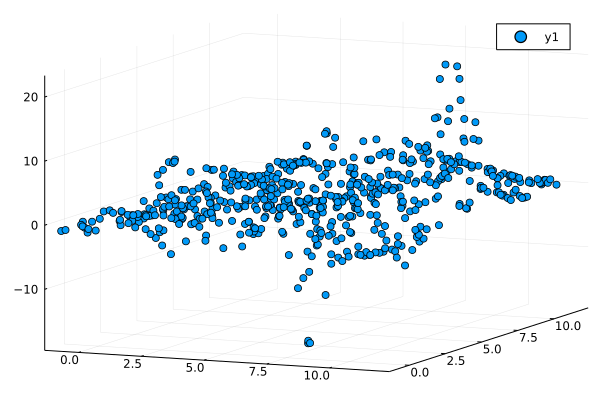

In [1252]:
p3d = scatter3d(X_2D[:,1], X_2D[:,2], sample2D)

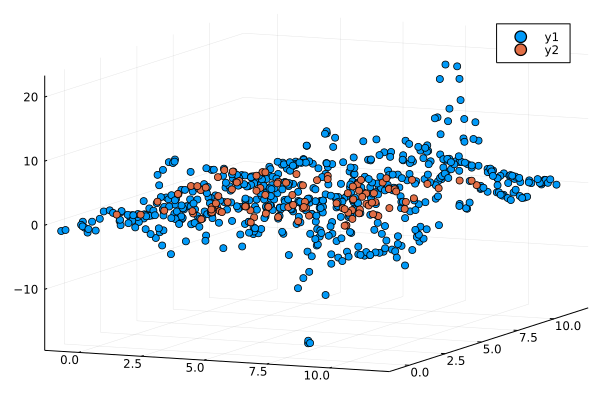

In [1253]:
scatter3d!(p3d, X_2D_train[:, 1], X_2D_train[:, 2], Y_2D_train)

# Artificial species occurrence data

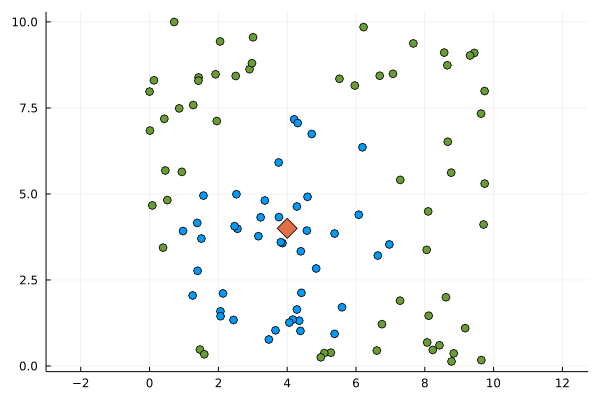

In [1297]:
n_data = 100
dim = 2
cent_1 = [4;4] # column matrix
rad_sq = 12
x = rand(n_data, dim)*10

z = x .- cent_1'
class_1 = map(z -> z ? 1 : 0, sum(z .^ 2, dims = 2) .< rad_sq);

p = scatter(x[:, 1], x[:, 2], m=:o, labels=false, color = class_1)
scatter!(p, [cent_1[1]], [cent_1[2]], m=:d, ms = 10, labels = false, aspect_ratio=:equal)

In [1298]:
X_2D_1 = rand(Uniform(-1, 12), 600)
X_2D_2 = rand(Uniform(-1, 12), 600)

X_2D = hcat(X_2D_1, X_2D_2);

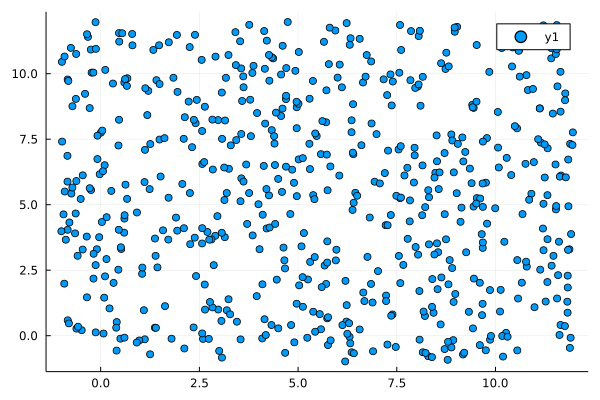

In [1299]:
scatter(X_2D[:, 1], X_2D[:, 2])

In [1300]:
Y_occurrence = [class_1[i] for i in 1:length(class_1)];

In [1301]:
X_2D_train = x;

In [1302]:
mu_s, cov_s = posterior_0_noise(X_2D, X_2D_train, Y_occurrence)

([1.0353823709272092, 0.344887728270193, 0.010020308395705224, 0.01349082442427104, 0.7530398720516809, -0.13439969703783086, 1.0301860362312798, -0.12779308313027316, 0.558853649509393, -0.07860525760665828  …  0.5168791653916394, 0.9321982697606099, 0.08298034123946785, 0.9933965127995066, -0.024189592426080875, -0.008816347646374956, 0.21188906131486895, 0.32923577681590643, 0.13658941544471226, 0.001935409101329718], [0.006409672592551874 2.4941162032791668e-5 … -6.734930101741021e-5 5.7774738510378e-7; 2.494116204346284e-5 0.1745589259425917 … 0.016664931914329106 0.0002935865755736419; … ; -6.734930102880808e-5 0.016664931914382647 … 0.015736709324753018 -9.71373530019991e-6; 5.777473864788606e-7 0.0002935865755735544 … -9.71373530018162e-6 0.9961621791764278])

In [1303]:
mv_norm_posterior_2D = MvNormal(mu_s, Matrix(Hermitian(cov_s)));

In [1304]:
sample2D = rand(mv_norm_posterior_2D)

600-element Vector{Float64}:
  1.1776146290772735
  0.409264380783083
  0.0961087729181049
 -0.029662064524631646
  0.8605674726034525
 -0.5988285844283534
  1.0960462230657713
 -0.2354302407366338
  0.38646245695891834
  0.668238236925217
  0.6346304408655125
 -0.17801981203438055
  0.26701430030641327
  ⋮
  0.17835463123901188
 -0.27567228023878515
  0.619478713479436
  1.0248540811879616
  0.13044504343885477
  1.168720854117493
  0.1479052196920919
  0.22108401387597543
  0.3344950956837096
  0.07515204719273988
  0.2475411043507228
 -1.4279208491773956

In [1305]:
for i in 1:1000
    temp = rand(mv_norm_posterior_2D)
    sample2D = hcat(sample2D, temp)
end

In [1307]:
sample_mean = mean(sample2D, dims = 2);

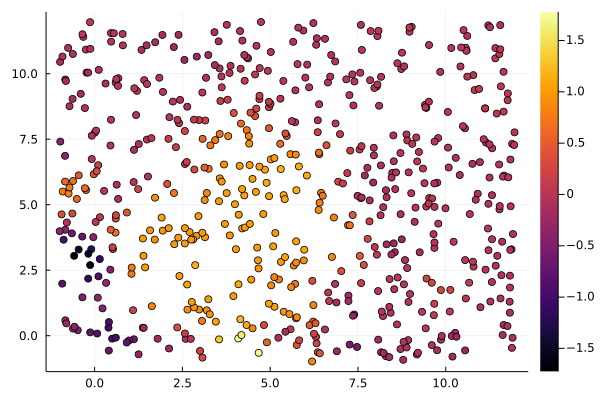

In [1308]:
scatter(X_2D[:,1], X_2D[:,2], marker_z = sample_mean, label = false)

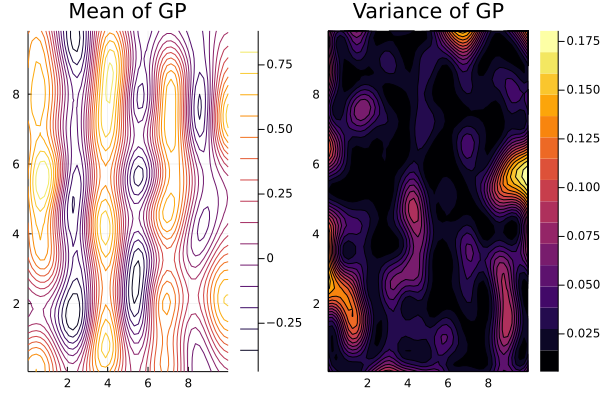

In [56]:
# Plot mean and variance
# p1 = plot(gp2; title="Mean of GP")
# p2 = plot(gp2; var=true, title="Variance of GP", fill=true)
# plot(p1, p2; fmt=:png)

In [1309]:
p = [logistic(sample_mean[i]) for i in 1:length(sample_mean)]

600-element Vector{Float64}:
 0.7378856115664743
 0.5864527498009632
 0.5045804634810618
 0.5028625041438737
 0.6817910605964053
 0.47083564140597994
 0.736460317522172
 0.47091473852268106
 0.6345933674631011
 0.46473654419667854
 0.6561795904029281
 0.4667939855812085
 0.4412967254164413
 ⋮
 0.5023438724855729
 0.4824705336521325
 0.625950250043143
 0.7173877836086907
 0.5217045702817423
 0.7302308509391072
 0.493418554654911
 0.5016768687678157
 0.555191070066914
 0.5805495812241414
 0.5356479799604491
 0.5113799604471961

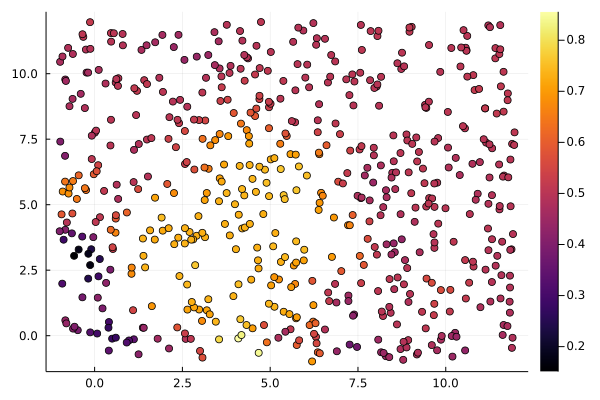

In [1310]:
scatter(X_2D[:,1], X_2D[:,2], marker_z = p, label = false)

## Transform into binary data with threshold

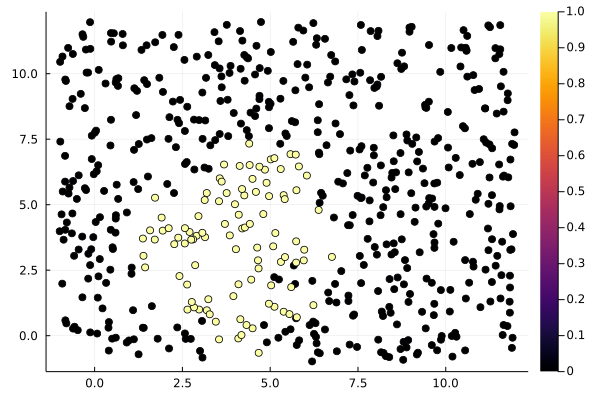

In [1318]:
threshold = 0.7
class__with_threshold = map(z -> z ? 1 : 0, p .> threshold)
scatter(X_2D[:,1], X_2D[:,2], marker_z = class__with_threshold, label = false)

## Transform into binary data with Bernoulli distribution

In [1328]:
p_bern_hat = [mean(rand(Bernoulli(p[i]), 10_000)) for i in 1:length(p)]

600-element Vector{Float64}:
 0.7365
 0.5901
 0.489
 0.5077
 0.6882
 0.4794
 0.7401
 0.4726
 0.636
 0.4677
 0.6502
 0.4599
 0.4315
 ⋮
 0.5001
 0.4876
 0.6249
 0.7257
 0.5179
 0.7334
 0.491
 0.5061
 0.5488
 0.5879
 0.5277
 0.5223

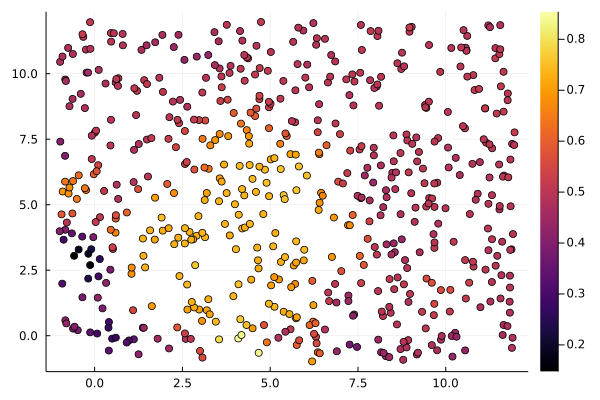

In [1329]:
scatter(X_2D[:,1], X_2D[:,2], marker_z = p_bern_hat, label = false)

# TODO

1. Optimize the negative log-likelihood function
2. Try for more variables
3. ?? Optimize the threshold with error measures.